# Ternary plots for vanilla classifiers

In [1]:
import os
import sys
import time
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from scipy import stats
from scipy.special import softmax
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense

from utils.ops import onehot_encode
from utils.data import get_cifar3
from utils.metrics import neg_log_likelihood, accuracy
from utils.visualization import plot_pdf_triplex, plot_prob_triplex
from calibrators import PAVCalibrator, NiceCalibrator, TempScalingCalibrator

In [2]:
%matplotlib inline

## Load IRIS dataset

In [3]:
iris = load_iris()
ix2label = {
    0: 'Setosa',
    1: 'Versicolour',
    2: 'Virginica'}

There are 50 samples per class, we can take 15 of each to form a validation set. Samples come ordered by class, the first 50 are class-0 samples, etc..

In [4]:
n_samples_class = 30

idxs0, idxs1, idxs2 = np.random.permutation(50), np.random.permutation(50)+50, np.random.permutation(50)+100

X_train = np.vstack((iris.data[idxs0[:n_samples_class], :],
                     iris.data[idxs1[:n_samples_class], :],
                     iris.data[idxs2[:n_samples_class], :]))
y_train = np.hstack((iris.target[idxs0[:n_samples_class]], iris.target[idxs1[:n_samples_class]], iris.target[idxs2[:n_samples_class]]))

X_test = np.vstack((iris.data[idxs0[n_samples_class:], :],
                    iris.data[idxs1[n_samples_class:], :],
                    iris.data[idxs2[n_samples_class:], :]))
y_test = np.hstack((iris.target[idxs0[n_samples_class:]], iris.target[idxs1[n_samples_class:]], iris.target[idxs2[n_samples_class:]]))

### Train a SVM

In [5]:
svc = SVC(kernel='rbf', probability=True);
svc.fit(X_train, y_train);

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [6]:
# Performance
print("Accuracy: {:.3f}".format(svc.score(X_train, y_train)))
print("Accuracy on the test set: {:.3f}".format(svc.score(X_test, y_test)))

probs = svc.predict_proba(X_train)
probs_test = svc.predict_proba(X_test)
print("Cross-entropy: {:.3f}".format(neg_log_likelihood(probs, y_train)))
print("Cross-entropy on the test set: {:.3f}".format(neg_log_likelihood(probs_test, y_test)))

Accuracy: 0.989
Accuracy on the test set: 0.983
Cross-entropy: 0.101
Cross-entropy on the test set: 0.093


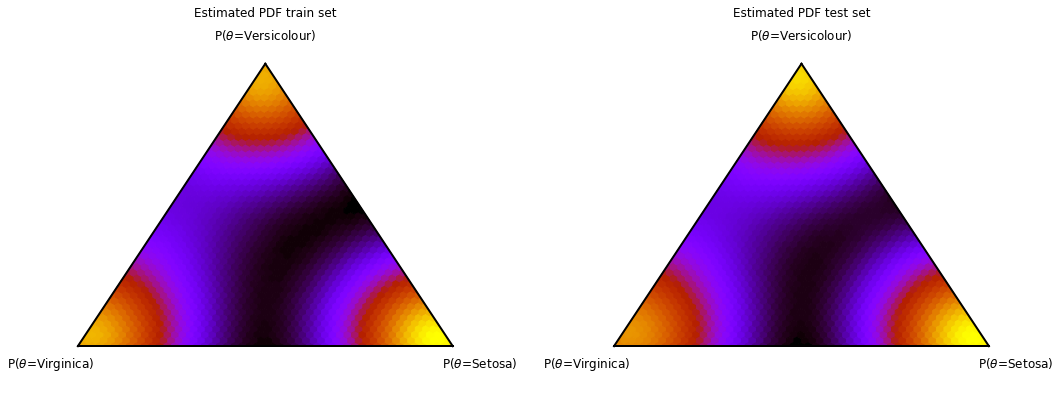

In [7]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_triplex(probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_triplex(probs_test, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

### Temperature Scaling effects 

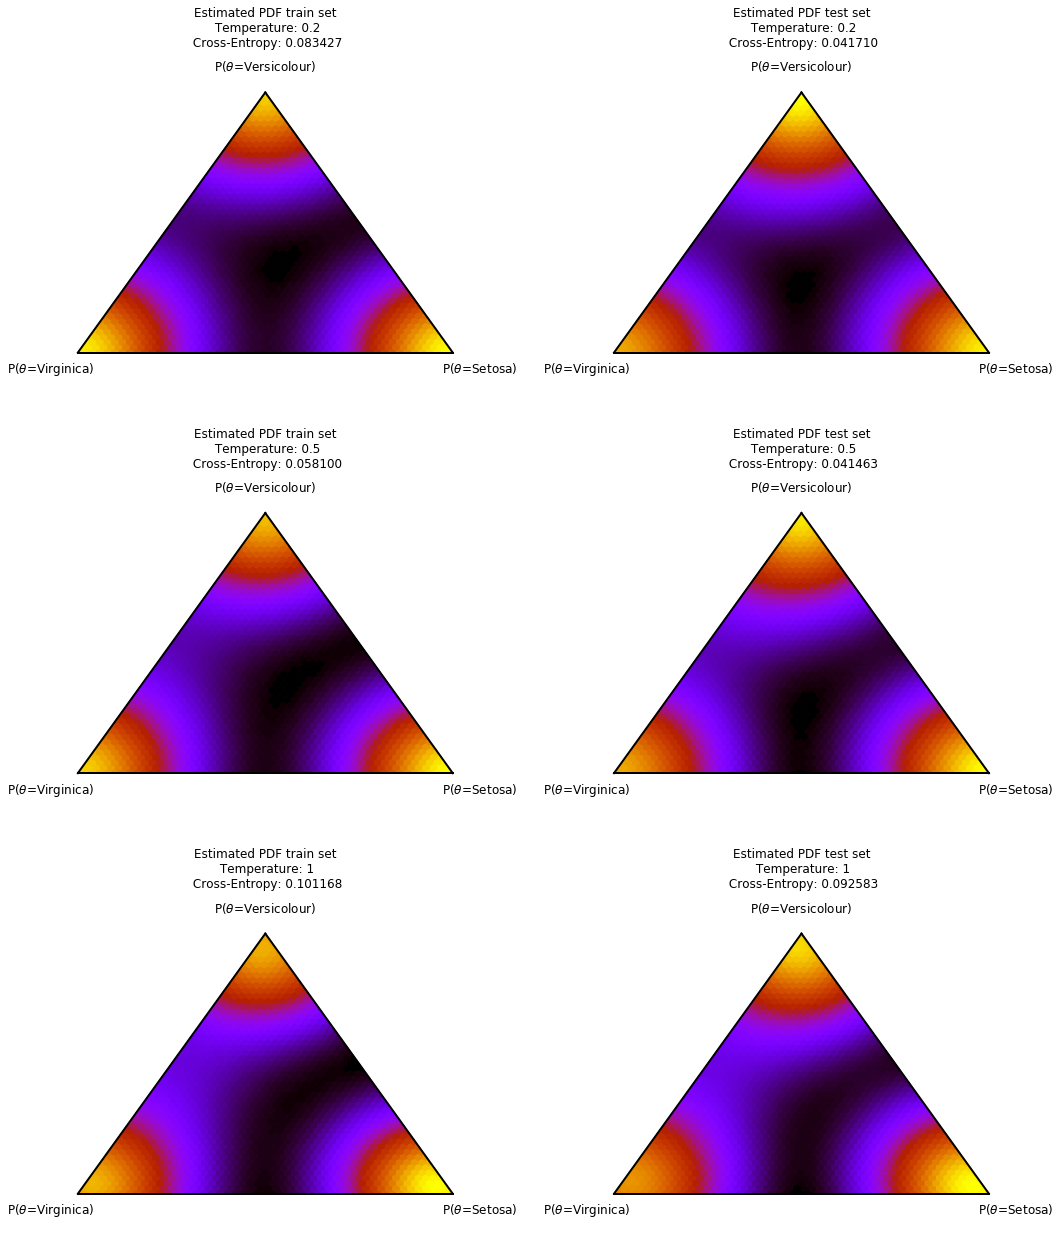

In [8]:
train_logits = svc.predict_log_proba(X_train)
test_logits = svc.predict_log_proba(X_test)

Ts = [0.2, 0.5, 1]
fig, ax_arr = plt.subplots(len(Ts), 2, figsize=(17, 7*len(Ts)), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

for i, T in enumerate(Ts):
    train_probs = softmax(train_logits/T, axis=1)
    test_probs = softmax(test_logits/T, axis=1)
    train_xentropy = neg_log_likelihood(train_probs, y_train)
    test_xentropy = neg_log_likelihood(test_probs, y_test)
    
    ax_arr[i, 0] = plot_pdf_triplex(train_probs, ax=ax_arr[i, 0],
                                 title='Estimated PDF train set\n Temperature: {}\n Cross-Entropy: {:3f}'.format(T, train_xentropy),
                                 fontsize=12, labels=list(ix2label.values()));
    ax_arr[i, 1] = plot_pdf_triplex(test_probs, ax=ax_arr[i, 1],
                                 title='Estimated PDF test set\n Temperature: {}\n Cross-Entropy: {:3f}'.format(T, test_xentropy),
                                 fontsize=12, labels=list(ix2label.values()));
plt.show()

### Optimum temperature

In [9]:
def optim_temperature(logits, target, min_diff=1e-5, step=0.1):
    T = 1.0
    probs = softmax(logits/T, axis=1)

    while True:
        # Compute gradient w.r.t. T
        one_hot = onehot_encode(target)
        grad = -np.mean(np.sum((probs-one_hot)*logits/T**2, axis=1))

        # Update step
        probs_new = softmax(logits/(T-grad*step), axis=1)

        if abs(grad*step) < min_diff:
            break

        T -= grad*step
        probs = probs_new

    return T

In [10]:
T_train = optim_temperature(train_logits, y_train)
T_test = optim_temperature(test_logits, y_test)

test_probs_train = softmax(test_logits/T_train, axis=1)
test_xentropy_train = neg_log_likelihood(test_probs_train, y_test)

test_probs_test = softmax(test_logits/T_test, axis=1)
test_xentropy_test = neg_log_likelihood(test_probs_test, y_test)

print("Optimum temperature for train set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_train, test_xentropy_train))
print("Optimum temperature for test set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_test, test_xentropy_test))

Optimum temperature for train set: 0.499
 achieves LNN=0.041 on test set
Optimum temperature for test set: 0.333
 achieves LNN=0.039 on test set


### Load CIFAR-3

In [11]:
data_path = '../cifar-10'
cifar3, ix2label = get_cifar3(data_path, target_labels=['airplane', 'automobile', 'bird'], test=True,
                              prior=[0.5, 0.2, 0.3], test_prior=[0.3, 0.5, 0.2])

### Train a simple classifier: PCA+Logistic

In [12]:
# Hyperparameters
n_components = 20

In [13]:
# Prepare data
y_train = cifar3['labels']
X_train = np.array([ima.flatten() for ima in cifar3['images']])

y_test = cifar3['test_labels']
X_test = np.array([ima.flatten() for ima in cifar3['test_images']])

In [14]:
# Fit PCA
pca = PCA(n_components=n_components, svd_solver='randomized',whiten=True).fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [15]:
# Train LogisticRegression
t0 = time.time()
logistic = LogisticRegression(solver='lbfgs', multi_class='multinomial').fit(X_train_pca, y_train)
print("Fitted in {:.3f}s".format(time.time() - t0))

Fitted in 0.030s


In [16]:
# Train and test performance
print("Accuracy on the train set: {}".format(logistic.score(X_train_pca, y_train)))
print("Accuracy on the test set: {}".format(logistic.score(X_test_pca, y_test)))

probs = logistic.predict_proba(X_train_pca)
test_probs = logistic.predict_proba(X_test_pca)
print("Cross-entropy on the train set: {}".format(neg_log_likelihood(probs, y_train)))
print("Cross-entropy on the test set: {}".format(neg_log_likelihood(test_probs, y_test)))

Accuracy on the train set: 0.7066
Accuracy on the test set: 0.637
Cross-entropy on the train set: 0.7342734229835732
Cross-entropy on the test set: 0.8565802020421275


## Visualizing results 

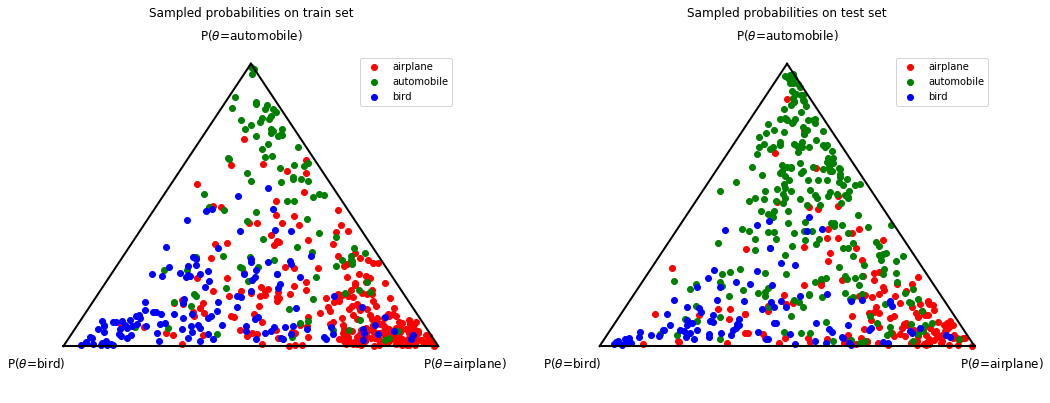

In [17]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_prob_triplex(probs[:500], target=y_train[:500], ax=ax_arr[0],
                              title='Sampled probabilities on train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_prob_triplex(test_probs[:500], target=y_test[:500], ax=ax_arr[1],
                              title='Sampled probabilities on test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

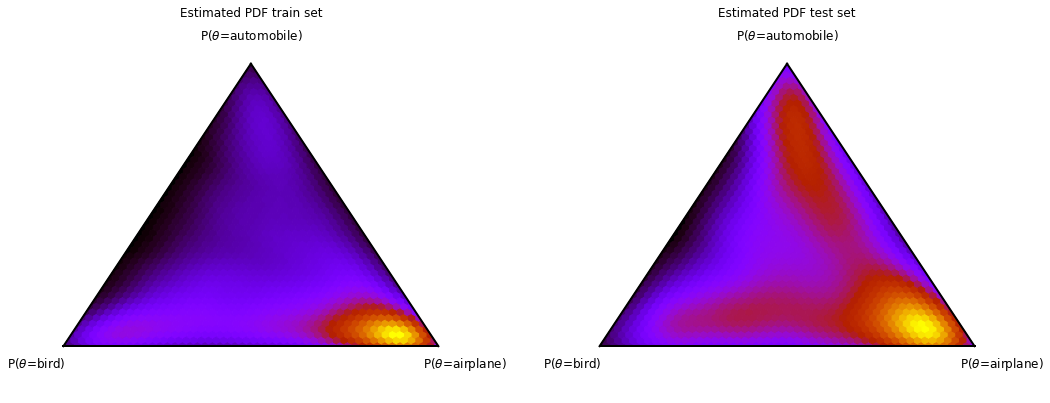

In [18]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_triplex(probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_triplex(test_probs, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

### Temperature Scaling effects

In [19]:
train_logits = logistic.predict_log_proba(X_train_pca)
test_logits = logistic.predict_log_proba(X_test_pca)

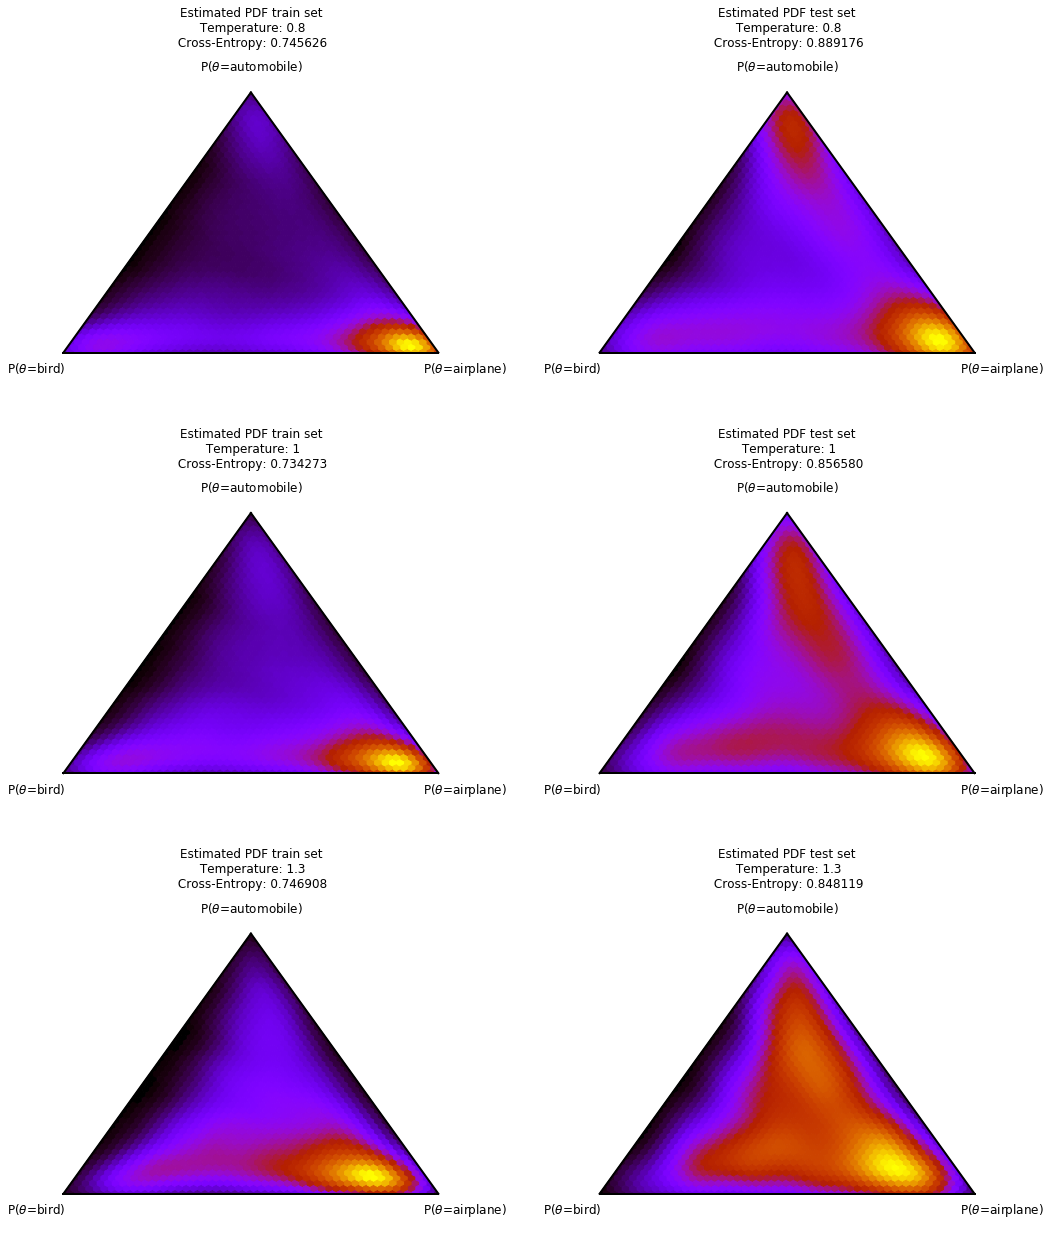

In [20]:
Ts = [0.8, 1, 1.3]
fig, ax_arr = plt.subplots(len(Ts), 2, figsize=(17, 7*len(Ts)), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

for i, T in enumerate(Ts):
    train_probs = softmax(train_logits/T, axis=1)
    test_probs = softmax(test_logits/T, axis=1)
    train_xentropy = neg_log_likelihood(train_probs, y_train)
    test_xentropy = neg_log_likelihood(test_probs, y_test)
    
    ax_arr[i, 0] = plot_pdf_triplex(train_probs, ax=ax_arr[i, 0],
                                 title='Estimated PDF train set\n Temperature: {}\n Cross-Entropy: {:3f}'.format(T, train_xentropy),
                                 fontsize=12, labels=list(ix2label.values()));
    ax_arr[i, 1] = plot_pdf_triplex(test_probs, ax=ax_arr[i, 1],
                                 title='Estimated PDF test set\n Temperature: {}\n Cross-Entropy: {:3f}'.format(T, test_xentropy),
                                 fontsize=12, labels=list(ix2label.values()));
plt.show()

In [21]:
T_train = optim_temperature(train_logits, y_train)
T_test = optim_temperature(test_logits, y_test)

test_probs_train = softmax(test_logits/T_train, axis=1)
test_xentropy_train = neg_log_likelihood(test_probs_train, y_test)

test_probs_test = softmax(test_logits/T_test, axis=1)
test_xentropy_test = neg_log_likelihood(test_probs_test, y_test)

print("Optimum temperature for train set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_train, test_xentropy_train))
print("Optimum temperature for test set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_test, test_xentropy_test))

Optimum temperature for train set: 0.999
 achieves LNN=0.857 on test set
Optimum temperature for test set: 1.239
 achieves LNN=0.848 on test set


## PCA + SVMLinear

In [22]:
# Train SVM
t0 = time.time()
svc = SVC(kernel='linear', probability=True);
svc.fit(X_train_pca, y_train);
print("Fitted in {:.3f}s".format(time.time() - t0))

Fitted in 26.992s


In [23]:
# Train and test performance
print("Accuracy on the train set: {}".format(svc.score(X_train_pca, y_train)))
print("Accuracy on the test set: {}".format(svc.score(X_test_pca, y_test)))

probs = svc.predict_proba(X_train_pca)
test_probs = svc.predict_proba(X_test_pca)
print("Cross-entropy on the train set: {}".format(neg_log_likelihood(probs, y_train)))
print("Cross-entropy on the test set: {}".format(neg_log_likelihood(test_probs, y_test)))

Accuracy on the train set: 0.7091
Accuracy on the test set: 0.6405
Cross-entropy on the train set: 0.7346973395784953
Cross-entropy on the test set: 0.8566265556300292


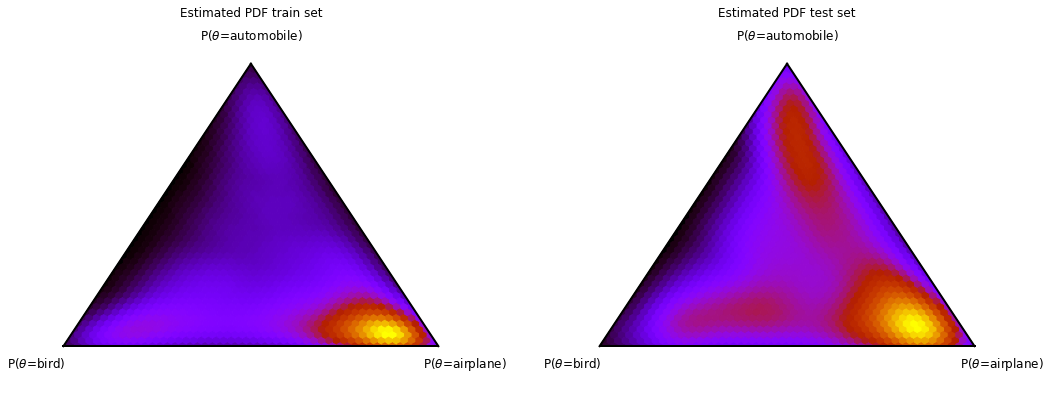

In [24]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_triplex(probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_triplex(test_probs, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

In [25]:
train_logits = svc.predict_log_proba(X_train_pca)
test_logits = svc.predict_log_proba(X_test_pca)

In [26]:
T_train = optim_temperature(train_logits, y_train)
T_test = optim_temperature(test_logits, y_test)

test_probs_train = softmax(test_logits/T_train, axis=1)
test_xentropy_train = neg_log_likelihood(test_probs_train, y_test)

test_probs_test = softmax(test_logits/T_test, axis=1)
test_xentropy_test = neg_log_likelihood(test_probs_test, y_test)

print("Optimum temperature for train set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_train, test_xentropy_train))
print("Optimum temperature for test set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_test, test_xentropy_test))

Optimum temperature for train set: 0.958
 achieves LNN=0.860 on test set
Optimum temperature for test set: 1.197
 achieves LNN=0.851 on test set


## PCA + SVMPolynomial

In [27]:
# Train SVM
t0 = time.time()
svc_poly = SVC(kernel='poly', degree=2, probability=True);
svc_poly.fit(X_train_pca, y_train);
print("Fitted in {:.3f}s".format(time.time() - t0))

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Fitted in 12.930s


In [28]:
# Train and test performance
print("Accuracy on the train set: {}".format(svc_poly.score(X_train_pca, y_train)))
print("Accuracy on the test set: {}".format(svc_poly.score(X_test_pca, y_test)))

probs = svc_poly.predict_proba(X_train_pca)
test_probs = svc_poly.predict_proba(X_test_pca)
print("Cross-entropy on the train set: {}".format(neg_log_likelihood(probs, y_train)))
print("Cross-entropy on the test set: {}".format(neg_log_likelihood(test_probs, y_test)))

Accuracy on the train set: 0.7319
Accuracy on the test set: 0.637
Cross-entropy on the train set: 0.666939750364281
Cross-entropy on the test set: 0.8231340125973245


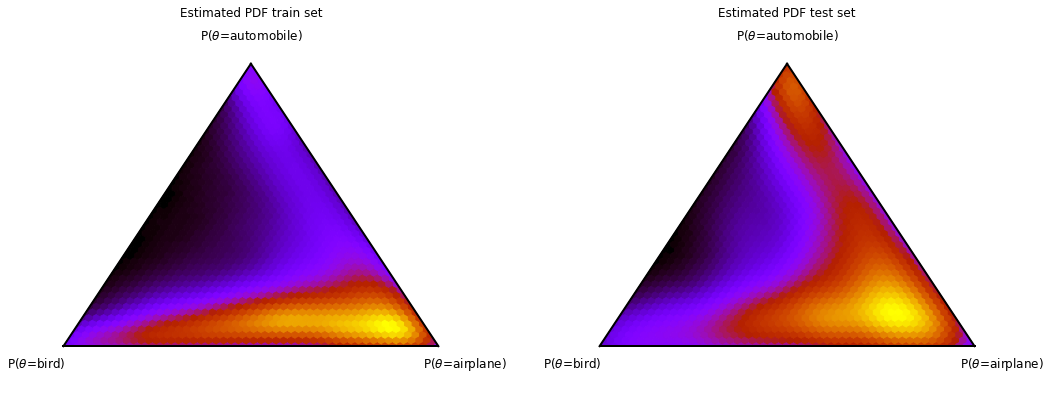

In [29]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_triplex(probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_triplex(test_probs, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

In [30]:
train_logits = svc_poly.predict_log_proba(X_train_pca)
test_logits = svc_poly.predict_log_proba(X_test_pca)

In [31]:
T_train = optim_temperature(train_logits, y_train)
T_test = optim_temperature(test_logits, y_test)

test_probs_train = softmax(test_logits/T_train, axis=1)
test_xentropy_train = neg_log_likelihood(test_probs_train, y_test)

test_probs_test = softmax(test_logits/T_test, axis=1)
test_xentropy_test = neg_log_likelihood(test_probs_test, y_test)

print("Optimum temperature for train set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_train, test_xentropy_train))
print("Optimum temperature for test set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_test, test_xentropy_test))

Optimum temperature for train set: 0.874
 achieves LNN=0.840 on test set
Optimum temperature for test set: 1.266
 achieves LNN=0.813 on test set


## PCA + SVMrbf 

In [32]:
# Train SVM
t0 = time.time()
svc_rbf = SVC(kernel='rbf', probability=True);
svc_rbf.fit(X_train_pca, y_train);
print("Fitted in {:.3f}s".format(time.time() - t0))

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Fitted in 16.493s


In [33]:
# Train and test performance
print("Accuracy on the train set: {}".format(svc_rbf.score(X_train_pca, y_train)))
print("Accuracy on the test set: {}".format(svc_rbf.score(X_test_pca, y_test)))

probs = svc_rbf.predict_proba(X_train_pca)
test_probs = svc_rbf.predict_proba(X_test_pca)
print("Cross-entropy on the train set: {}".format(neg_log_likelihood(probs, y_train)))
print("Cross-entropy on the test set: {}".format(neg_log_likelihood(test_probs, y_test)))

Accuracy on the train set: 0.8635
Accuracy on the test set: 0.765
Cross-entropy on the train set: 0.37841247966479286
Cross-entropy on the test set: 0.5632821598013897


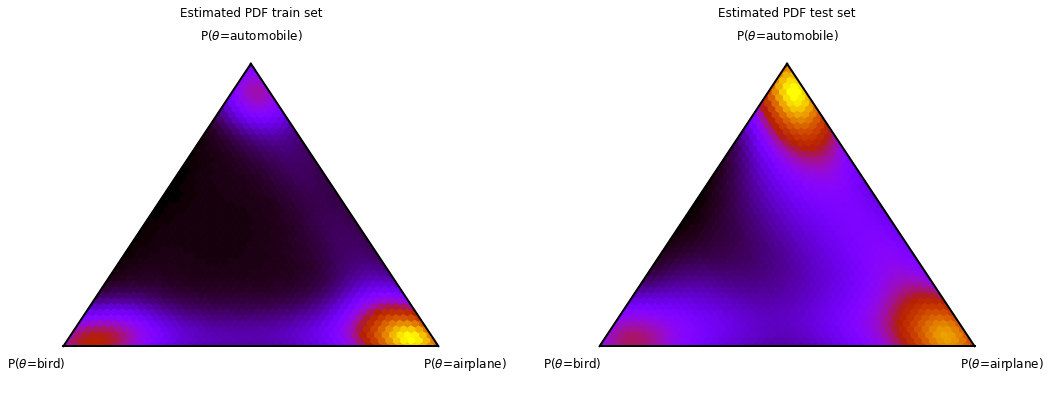

In [34]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_triplex(probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_triplex(test_probs, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

In [35]:
train_logits = svc_rbf.predict_log_proba(X_train_pca)
test_logits = svc_rbf.predict_log_proba(X_test_pca)

In [36]:
T_train = optim_temperature(train_logits, y_train)
T_test = optim_temperature(test_logits, y_test)

test_probs_train = softmax(test_logits/T_train, axis=1)
test_xentropy_train = neg_log_likelihood(test_probs_train, y_test)

test_probs_test = softmax(test_logits/T_test, axis=1)
test_xentropy_test = neg_log_likelihood(test_probs_test, y_test)

print("Optimum temperature for train set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_train, test_xentropy_train))
print("Optimum temperature for test set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_test, test_xentropy_test))

Optimum temperature for train set: 0.789
 achieves LNN=0.582 on test set
Optimum temperature for test set: 1.040
 achieves LNN=0.563 on test set


# Renset20

In [37]:
resnet_path = '../pretrained-models'

In [38]:
model = tf.keras.models.load_model(os.path.join(resnet_path, 'resnet20v1_cf3.h5'), custom_objects={'tf': tf})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [39]:
# Compute predictions
train_probs = model.predict(cifar3['images'])
test_probs = model.predict(cifar3['test_images'])

In [40]:
# Train and test performance
print("Accuracy on the train set: {}".format(accuracy(train_probs, y_train)))
print("Accuracy on the test set: {}".format(accuracy(test_probs, y_test)))


print("Cross-entropy on the train set: {}".format(neg_log_likelihood(train_probs, y_train)))
print("Cross-entropy on the test set: {}".format(neg_log_likelihood(test_probs, y_test)))

Accuracy on the train set: 0.9521
Accuracy on the test set: 0.946
Cross-entropy on the train set: 0.13045923500865875
Cross-entropy on the test set: 0.14423967094167103


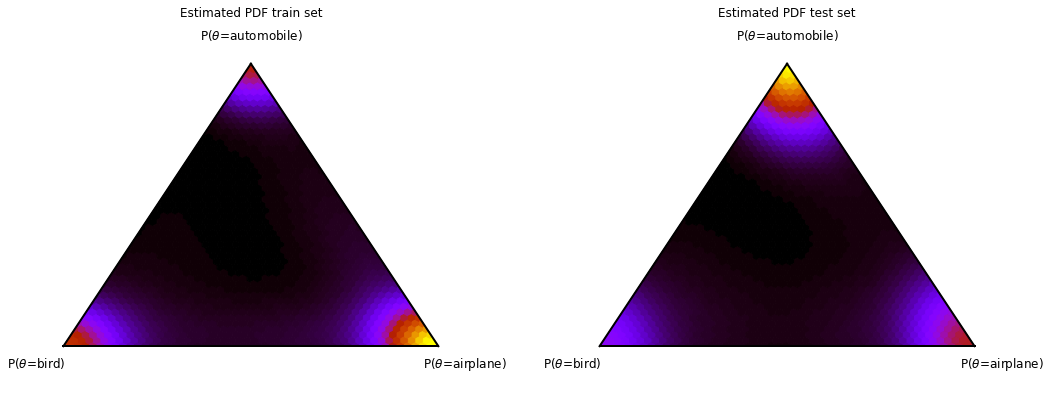

In [41]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_triplex(train_probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_triplex(test_probs, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

## Calibrating resnet
### Obtain the logits

In [42]:
logits = np.log(model.predict(cifar3['test_images']).astype(np.float))
target = onehot_encode(y_test.astype(np.int))

### Temperature Scaling 

In [43]:
# Temp scaling
t0 = time.time()
temp_cal = TempScalingCalibrator(logits, target)
print("Optimal temperature found: {:.3f}, elapsed time: {:.3f}s".format(temp_cal.T, (time.time()-t0)))
temp_probs = temp_cal.predict(logits)

temp_nll = neg_log_likelihood(temp_probs, target)
temp_acc = accuracy(temp_probs, target)

print("Negative log-likelihood after calibration with temp-scaling: {:.3f}".format(temp_nll))
print("Accuracy after calibration with temp-scaling: {:.3f}".format(temp_acc))

Optimal temperature found: 1.236, elapsed time: 0.060s
Negative log-likelihood after calibration with temp-scaling: 0.140
Accuracy after calibration with temp-scaling: 0.946


Effect on simplex:

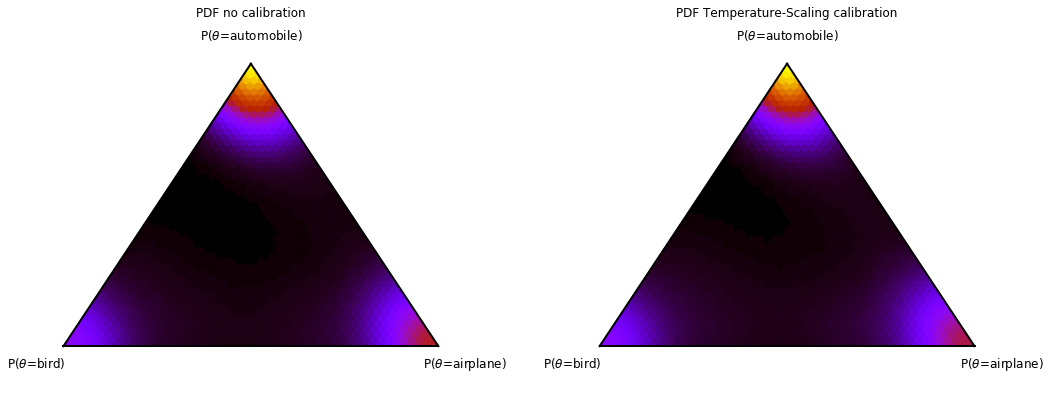

In [44]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_triplex(test_probs, ax=ax_arr[0], title='PDF no calibration', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_triplex(temp_probs, ax=ax_arr[1], title='PDF Temperature-Scaling calibration', fontsize=12, labels=list(ix2label.values()));
plt.show()

### PAV calibration 

In [45]:
t0 = time.time()
pav_cal = PAVCalibrator(logits, target)
print("PAV calibration fitted, elapsed time: {:.3f}s".format(time.time()-t0))

PAV calibration fitted, elapsed time: 0.003s


In [46]:
pav_probs = pav_cal.predict(logits.astype(np.float))

pav_nll = neg_log_likelihood(pav_probs, y_test)
pav_acc = accuracy(pav_probs, y_test)

print("Negative log-likelihood after calibration with temp-scaling: {:.3f}".format(pav_nll))
print("Accuracy after calibration with temp-scaling: {:.3f}".format(pav_acc))

Negative log-likelihood after calibration with temp-scaling: 0.104
Accuracy after calibration with temp-scaling: 0.960


Effects on probability simplex:

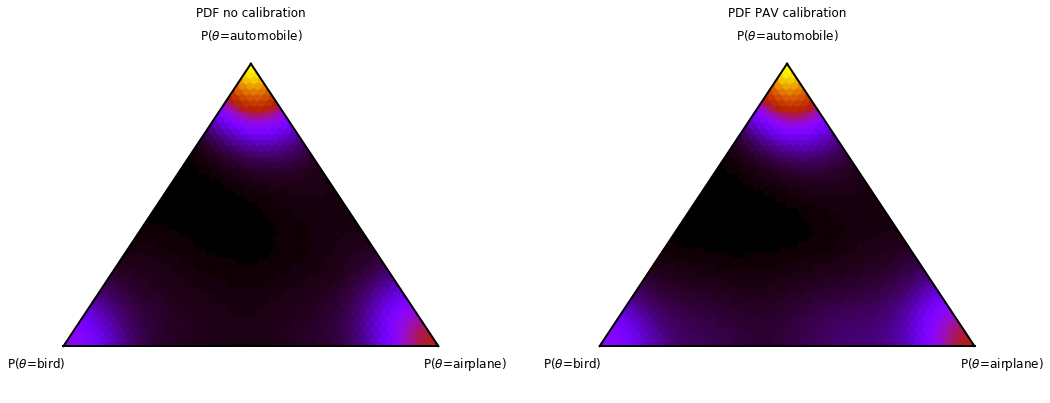

In [47]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_triplex(test_probs, ax=ax_arr[0], title='PDF no calibration', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_triplex(pav_probs, ax=ax_arr[1], title='PDF PAV calibration', fontsize=12, labels=list(ix2label.values()));
plt.show()

### NICE calibration

In [52]:
t0 = time.time()
nice_cal = NiceCalibrator(logits, target, layers=4,
                          hidden_size=[5, 5, 5], epochs=1000, batch_size=100)
print("NICE-flow calibration fitted, elapsed time: {:.3f}s".format(time.time()-t0))

NICE-flow calibration fitted, elapsed time: 109.339s


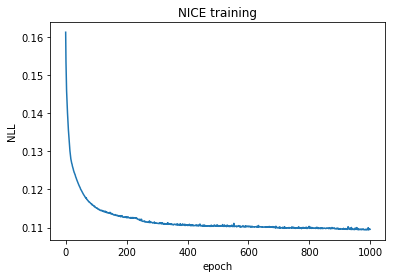

In [53]:
# Visalize training
plt.plot(nice_cal.history.history['loss'])
plt.title('NICE training')
plt.ylabel('NLL')
plt.xlabel('epoch')
plt.show()

In [54]:
nice_probs = nice_cal.predict(logits)

nll_nice = neg_log_likelihood(nice_probs, y_test)
nice_acc = accuracy(nice_probs, y_test)

print("Negative log-likelihood after calibration with NICE: {:.3f}".format(nll_nice))
print("Accuracy after calibration with NICE: {:.3f}".format(nice_acc))

Negative log-likelihood after calibration with NICE: 0.109
Accuracy after calibration with NICE: 0.957


Effects on probability simplex:

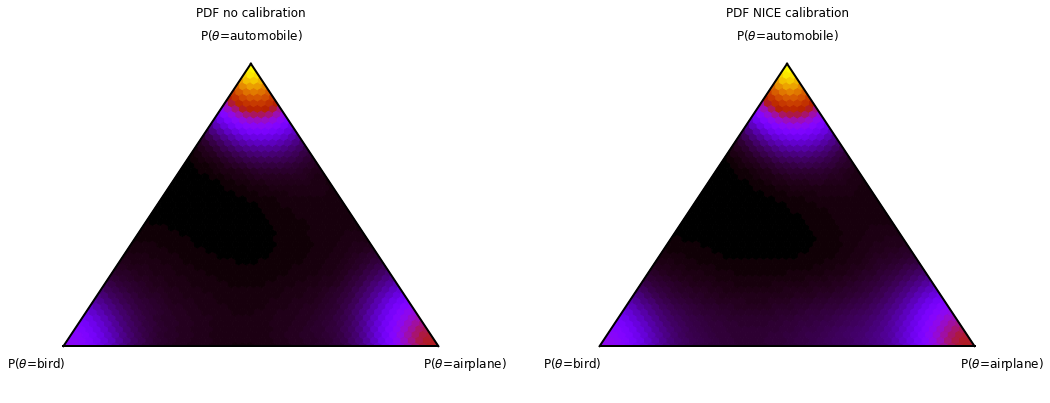

In [55]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_triplex(test_probs, ax=ax_arr[0], title='PDF no calibration', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_triplex(nice_probs, ax=ax_arr[1], title='PDF NICE calibration', fontsize=12, labels=list(ix2label.values()));
plt.show()